[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mohamed-Mehira/AI-computer-vision/blob/master/Pytorch/cifar10_CNN.ipynb)

# CIFAR-10 dataset

<p style="font-size: 15px;">
The CIFAR-10 dataset consists of 60000 32x32 colour images (3 channels) in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
</p>

## Importing needed modules/libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, sqrt

## Device configuration

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Hyperparameters

In [3]:
batch_size = 64
learning_rate = 0.002
num_epochs = 5

## Loading the dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='dataset/', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.CIFAR10(root='dataset/', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


## Define the CNN model

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Initializing the model

In [6]:
model = CNN().to(device)

## Loss & Optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Train Network

In [8]:
# loss_history = []
# num_correct_history = []

for epoch in range(num_epochs):
    
    running_loss = 0
    num_correct = 0
    
    for images, labels in train_loader:
        images = images.to(device=device)
        labels = labels.to(device=device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predictions = outputs.max(1)
        running_loss += loss.item()
        num_correct += (predictions == labels).sum()

    epoch_loss = running_loss/50000
    epoch_accuracy = num_correct.float()/50000
    # loss_history.append(epoch_loss)
    # num_correct_history.append(epoch_accuracy.cpu().numpy())
    # we can use this to plot the loss and accuracy of our model
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy.item():.4f}')

Epoch [1/5], Loss: 0.0217, Accuracy: 0.4905
Epoch [2/5], Loss: 0.0149, Accuracy: 0.6636
Epoch [3/5], Loss: 0.0121, Accuracy: 0.7292
Epoch [4/5], Loss: 0.0102, Accuracy: 0.7714
Epoch [5/5], Loss: 0.0088, Accuracy: 0.8006


## Testing (evaluation)

In [9]:
num_correct = 0
num_total = 0

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device=device)
        labels = labels.to(device=device)

        outputs = model(images)
        _, predictions = outputs.max(1)
        num_correct += (predictions == labels).sum()
        num_total += predictions.size(0)

    print(f'Accuracy on test data is {float(num_correct)/float(num_total)*100:.2f}%')

Accuracy on test data is 74.09%


## Visualizing predictions

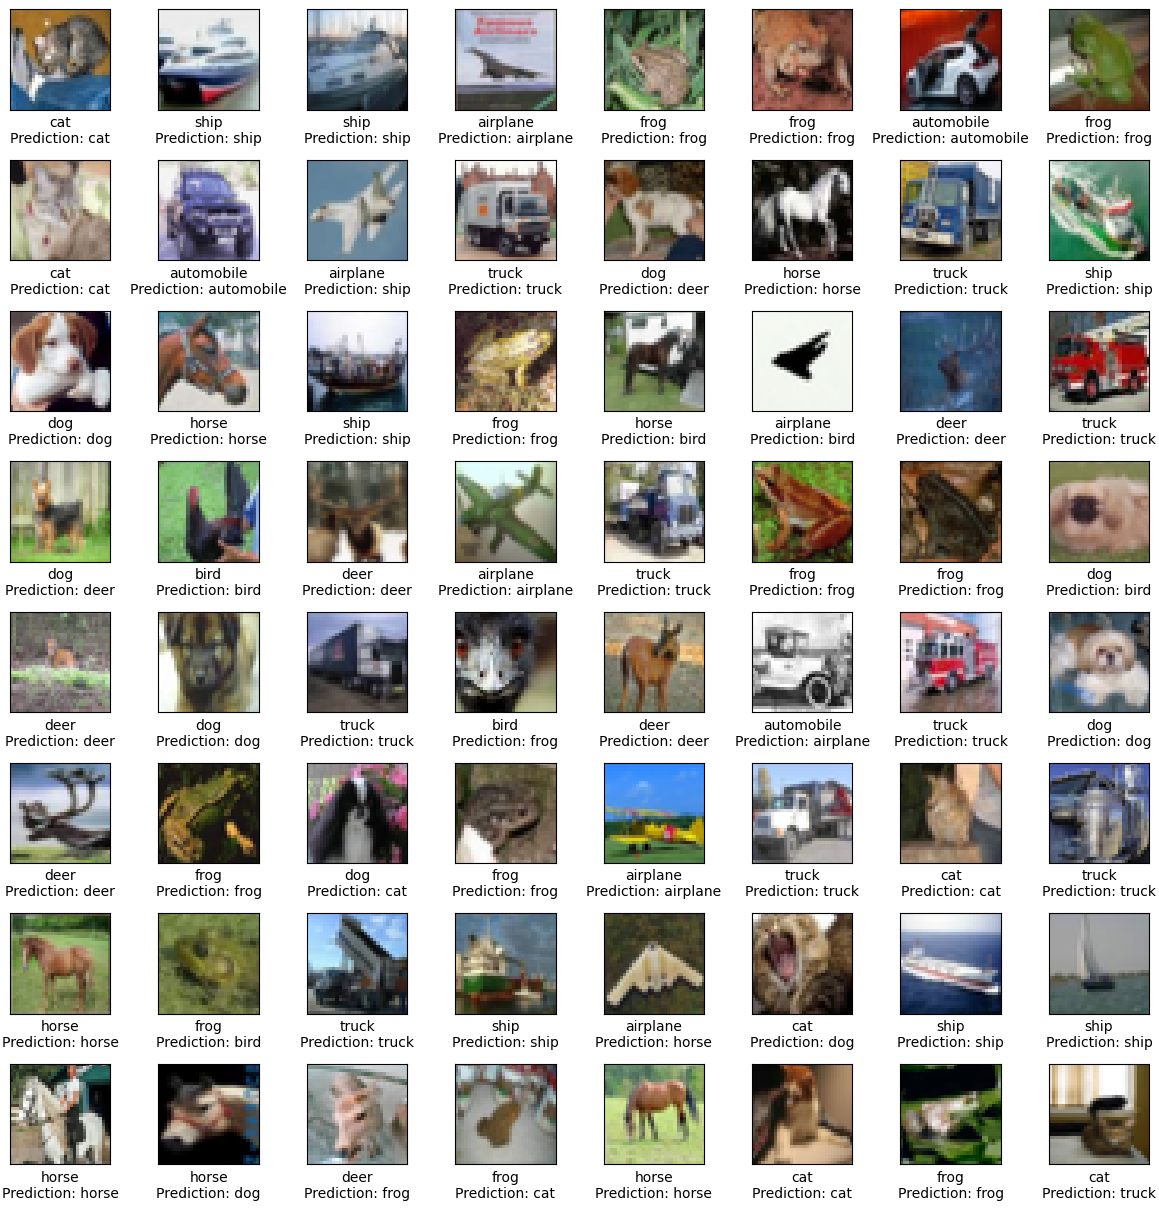

In [ ]:
def show(images, labels, pred_labels=None, img_num=32):
    plt.figure(figsize=(15, 15))
    for i in range(img_num):
        x = ceil(sqrt(img_num))
        plt.subplot(x, x, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        label = class_names[labels[i]]
        if pred_labels is not None:
            label += "\nPrediction: " + class_names[pred_labels[i]]
        plt.xlabel(label)
    plt.subplots_adjust(hspace=0.5)
    plt.show()

predictions = []
all_images = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        images = (images + 1) / 2
        all_images.append(images)
        all_labels.append(labels)

all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)

img_num = 64  # number of images you want to display (has to be even)
show(all_images.cpu().numpy(), all_labels.cpu().numpy(), predictions, img_num)